# Mahtab Nejati
# 98209434
# Problem 04

In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import classification_report,confusion_matrix

## 1. Load in data

In [2]:
train = sio.loadmat('./q4/train.mat')
test = sio.loadmat('./q4/test.mat')

### Training data metadata

In [3]:
print(type(train))
for key in train.keys():
    print(key)

<class 'dict'>
__header__
__version__
__globals__
X
y


In [4]:
x_train = train['X']
y_train = train['y']

cols = list(range(x_train.shape[1]))
train_df = pd.DataFrame(x_train,columns=cols)
train_df['y'] = y_train

print('Training data size:\tFeatures:'+str(x_train.shape[1])+'\tSamples:'+str(len(y_train)))

Training data size:	Features:1899	Samples:4000


### Test data metadata

In [5]:
print(type(test))
for key in test.keys():
    print(key)

<class 'dict'>
__header__
__version__
__globals__
Xtest
ytest


In [6]:
x_test = test['Xtest']
y_test = test['ytest']

print('Training data size:\tFeatures:'+str(x_test.shape[1])+'\tSamples:'+str(len(y_test)))

Training data size:	Features:1899	Samples:1000


## 2. Displaying

In [7]:
rndperm = np.random.permutation(x_train.shape[0])

### Displaying with PCA decomposition

In [8]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(train_df[cols].values)
train_df['pca_1'] = pca_result[:,0]
train_df['pca_2'] = pca_result[:,1] 
train_df['pca_3'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.10666594 0.02282151 0.0166218 ]


#### First two principal componets (not really useful)

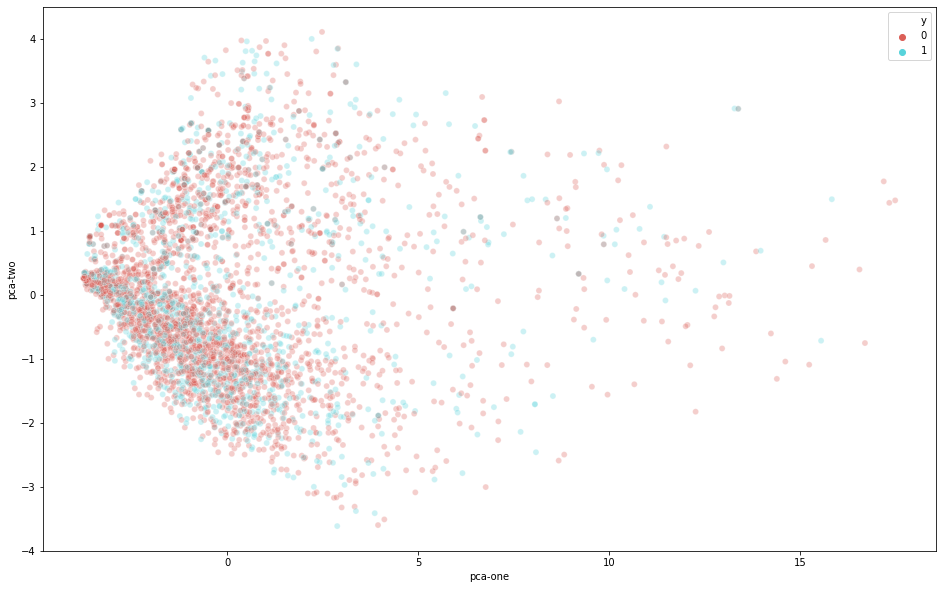

In [9]:
plt.figure(figsize=(16,10))
ax = sns.scatterplot(x=train_df['pca_1'].values, 
                     y=train_df['pca_2'].values,
                     hue="y",
                     palette=sns.color_palette("hls", 2),
                     data=train_df.loc[rndperm,:],
                     legend="full",
                     alpha=0.3)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
plt.show()

#### First three principal components

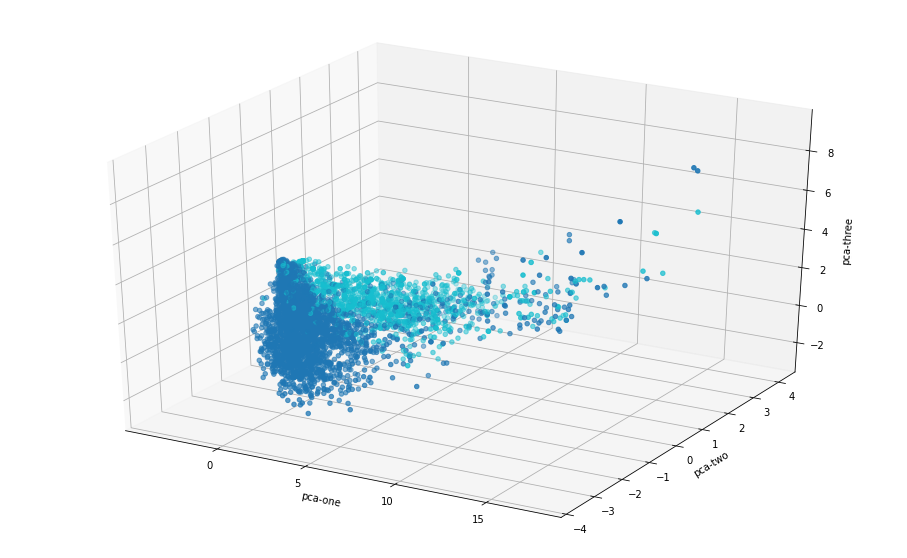

In [10]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(xs=train_df.loc[rndperm,:]["pca_1"], 
           ys=train_df.loc[rndperm,:]["pca_2"], 
           zs=train_df.loc[rndperm,:]["pca_3"], 
           c=train_df.loc[rndperm,:]["y"], 
           cmap='tab10')
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

### Displaying with T-SNE with two dimensions

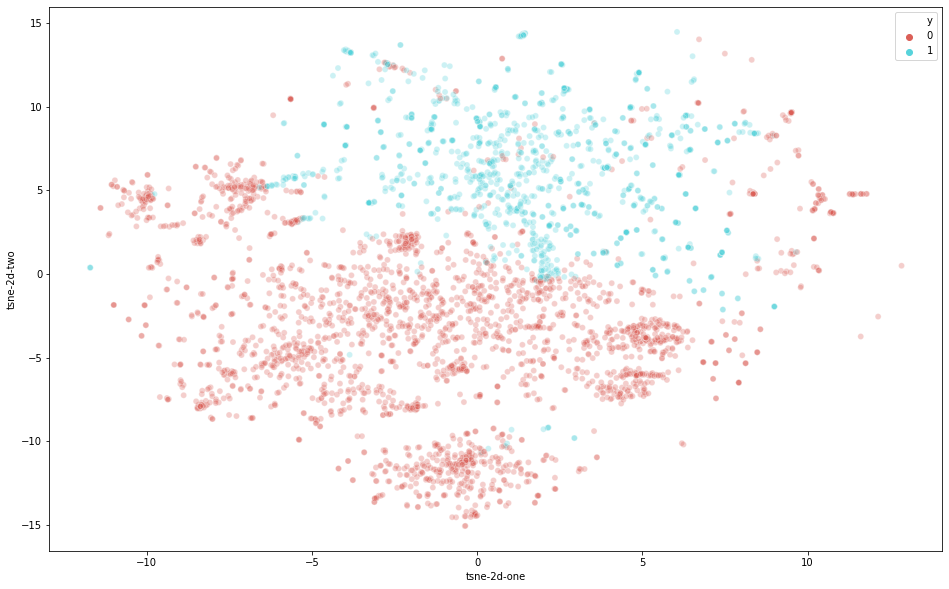

In [11]:
tsne = TSNE(n_components=2, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(train_df)
train_df['tsne-2d-one'] = tsne_results[:,0]
train_df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", 
                y="tsne-2d-two",
                hue="y",
                palette=sns.color_palette("hls", 2),
                data=train_df,
                legend="full",
                alpha=0.3)
plt.show()

### Histogram of frequency of words
#### It's a long tail and we can drop less frequent words. But it's just one of the problems of a homework so it shouldn't get any more complicated. Right? :D

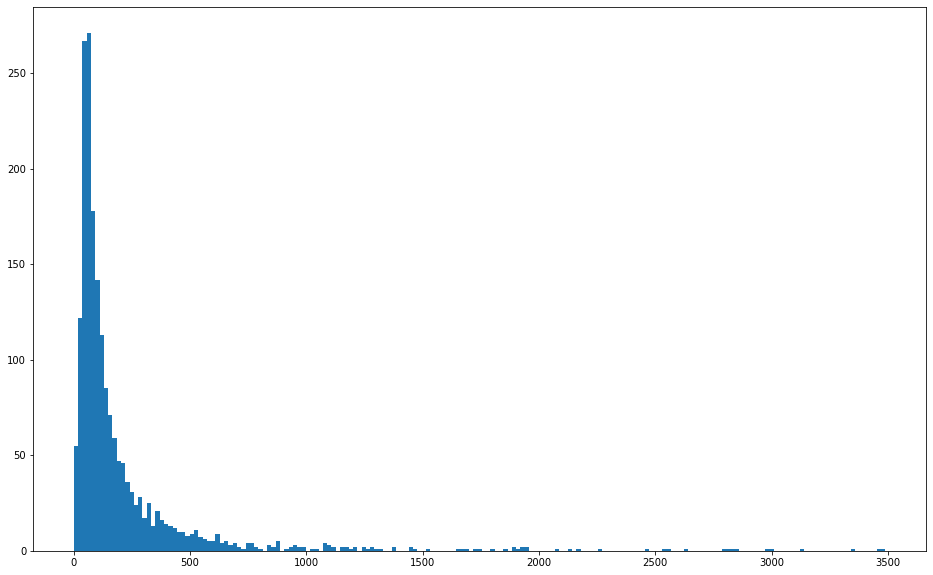

In [12]:
freqs = np.sum(x_train,axis=0)
plt.figure(figsize=(16,10))
plt.hist(freqs, bins=x_train.shape[1]//10)
plt.show()

### Histogram of number of words per email

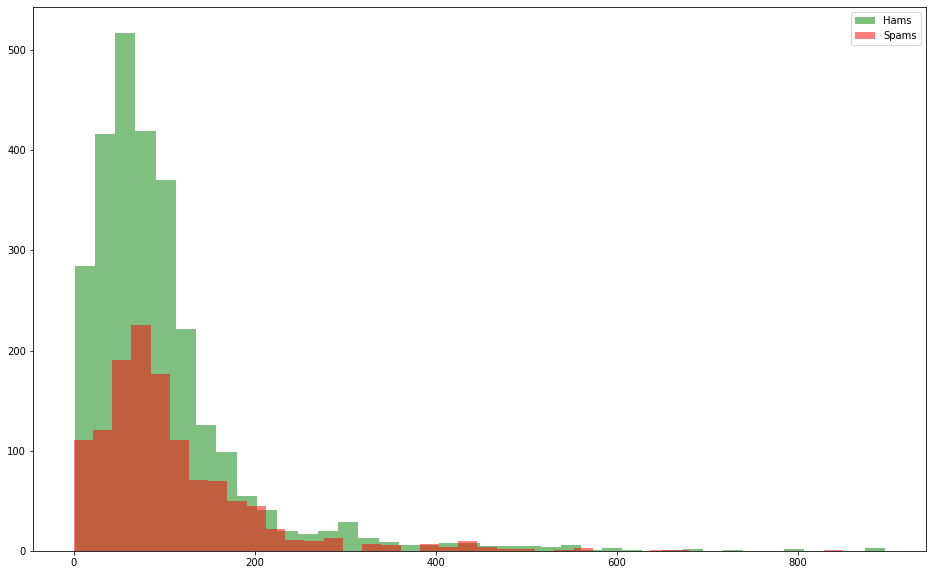

In [13]:
train_df['word_count'] = np.sum(x_train,axis=1)
spams = train_df.loc[train_df.y==1]['word_count'].values
hams = train_df.loc[train_df.y==0]['word_count'].values

kwargs = dict(alpha=0.5, bins=x_train.shape[0]//100)

plt.figure(figsize=(16,10))
plt.hist(hams, **kwargs, color='g', label='Hams')
plt.hist(spams, **kwargs, color='r', label='Spams')
plt.legend()
plt.show()

## 3.1. Training the classifier

### I will be using scikit-learn's implementation of Support Vector Machine (SVM) model.
### As for different kernels, there are four options: 
#### 1. Linear, which is best used only when the data is linearly separable, 
#### 2. Polynomial, denoted as poly, which is not recommended unless absolutely necessary because of computation expenses it imposes while not revealing the best results, 
#### 3. sigmoid,
#### 4. and finally the best and most recommended kernel, Gaussian (denoted as rbf). 
### To get the optimal kernel for the model, I have performed a grid search using GridSearchCV from scikit-learn's model_selection module. This search technique is used for exhaustive search over specified parameter values for an estimator to determine the optimal set of parameters. The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid. GridSearchCV tries out all the possible combinations of the specified parameters and returns the chooses the optimal parameters according to the cross-validation results. GridSearchCV implements a “fit” and a “score” method. It also implements “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” if they are implemented in the estimator used. RandomizedSearchCV is another method from scikit-learn's model_selection module that has a similar functionality. The reason I haven't opted for using this method is that in contrast to GridSearchCV, not all parameter values are tried out in this method, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by n_iter but why go the extra mile and pass an argument when I need to search all possible kernels...
### Note that I have only tested a polynomial model with a default degree of 3 due to computation time.

In [14]:
parameters = { 'kernel': ['linear', 'poly',  'sigmoid', 'rbf']}
best_model = GridSearchCV(SVC(), parameters)
best_model.fit(x_train, y_train.ravel())
print('Best Model Parameters:',end='\t')
print(best_model.best_params_) 

Best Model Parameters:	{'kernel': 'rbf'}


## 3.2. Metrics on training data

### Using classification_report from scikit-learn's metrics module, metrics such as precision, recall, f1-score, and support are reported below.

In [15]:
train_predictions = best_model.predict(x_train)
print(classification_report(y_train, train_predictions))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2723
           1       1.00      0.98      0.99      1277

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000



### Also, confusion matrix of the classification results are displayed below using a heatmap plot.

In [16]:
train_conf_matrix = confusion_matrix(y_train, train_predictions)

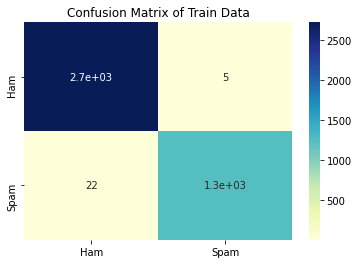

In [17]:
train_df_cm = pd.DataFrame(train_conf_matrix, index = ['Ham','Spam'], columns =  ['Ham','Spam'])
sns.heatmap(train_df_cm, annot=True, cmap="YlGnBu")
plt.title('Confusion Matrix of Train Data')
plt.show()

## 4. Metrics on test data

### Using classification_report from scikit-learn's metrics module, metrics such as precision, recall, f1-score, and support are reported below.

In [18]:
test_predictions = best_model.predict(x_test)
print(classification_report(y_test, test_predictions))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       692
           1       0.99      0.97      0.98       308

    accuracy                           0.99      1000
   macro avg       0.99      0.98      0.98      1000
weighted avg       0.99      0.99      0.99      1000



### Also, confusion matrix of the classification results are displayed below using a heatmap plot.

In [19]:
test_conf_matrix = confusion_matrix(y_test, test_predictions)

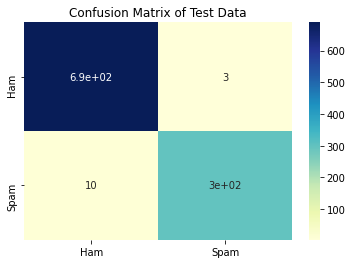

In [20]:
test_df_cm = pd.DataFrame(test_conf_matrix, index = ['Ham','Spam'], columns =  ['Ham','Spam'])
sns.heatmap(test_df_cm, annot=True, cmap="YlGnBu")
plt.title('Confusion Matrix of Test Data')
plt.show()